In [ ]:
# Bibliotecas
install.packages(c("tidyverse", "fitdistrplus", "kableExtra", "vcd", "readxl"))
library(tidyverse)
library(ggplot2)
library(fitdistrplus)
library(knitr)
library(kableExtra)
library(vcd)
library(readxl)

In [4]:
# Lendo o arquivo
df <- read_excel("insurance_claims.xlsx")

In [ ]:
# Selecionado colunas certas
carteira <- df[c(4, 31)]
carteira$date_of_accident <- as.Date(carteira$date_of_accident)
carteira$ano <- format(carteira$date_of_accident, "%Y")

# Agrupando por ano
carteira_agrupada <- carteira %>%
  group_by(ano) %>%
  summarise(
    total_por_ano = sum(total_claim_amount),
    quantidade_sinistros = n()
  ); carteira_agrupada

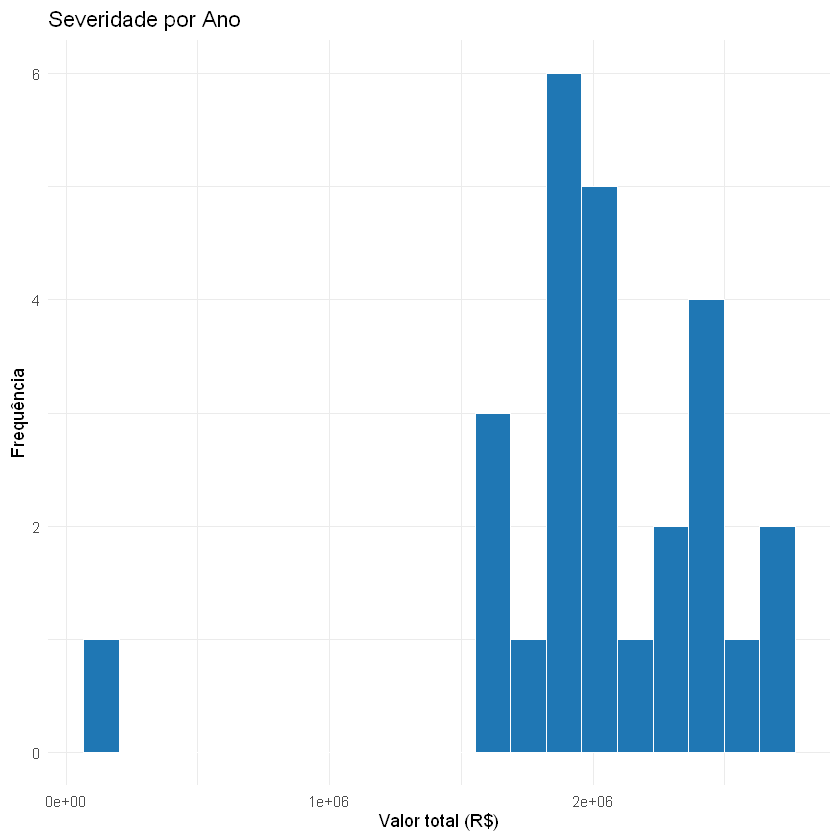

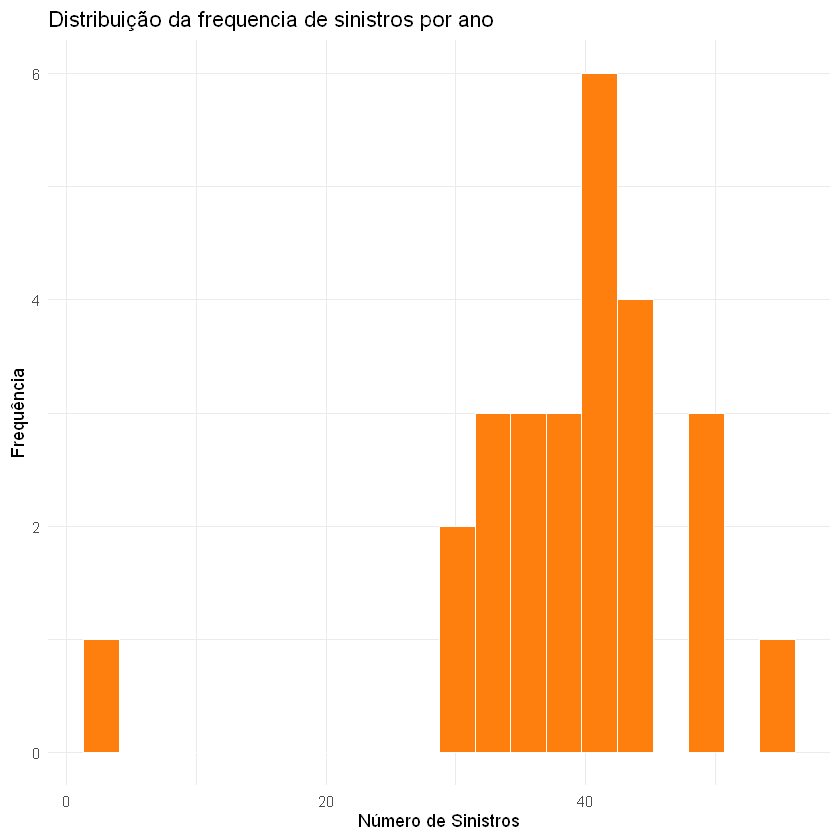

In [18]:
# Histograma total por ano
ggplot(carteira_agrupada, aes(x = total_por_ano)) +
  geom_histogram(fill = "#1f77b4", color = "white", bins = 20) +
  labs(
    title = "Severidade por Ano",
    x = "Valor total (R$)",
    y = "Frequência"
  ) +
  theme_minimal()

# Histograma quantidade de sinsitros por ano
ggplot(carteira_agrupada, aes(x = quantidade_sinistros)) +
  geom_histogram(fill = "#ff7f0e", color = "white", bins = 20) +
  labs(
    title = "Distribuição da frequencia de sinistros por ano",
    x = "Número de Sinistros",
    y = "Frequência"
  ) +
  theme_minimal()

In [19]:
# Obtendo estatísticas
estatisticas <- carteira_agrupada %>%
  summarise(
    media_severidade = mean(total_por_ano, na.rm = TRUE),
    var_severidade = var(total_por_ano, na.rm = TRUE),
    dp_severidade = sd(total_por_ano, na.rm = TRUE),
    media_qnt_sinistro = mean(quantidade_sinistros, na.rm = TRUE),
    var_qnt_sinistros = var(quantidade_sinistros, na.rm = TRUE),
    dp_qnt_sinistros = sd(quantidade_sinistros, na.rm = TRUE)
  ); estatisticas

media_severidade,var_severidade,dp_severidade,media_qnt_sinistro,var_qnt_sinistros,dp_qnt_sinistros
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2029305,249969858594,499969.9,38.46154,88.81846,9.424355


In [22]:
# Testes de aderência (uma amostra) para frequênica de sinistros
dados <- carteira_agrupada$quantidade_sinistros

# Parametros das distribuições pelo método da maximaverossimilhança
ajuste_pois <- fitdist(dados, "pois", method = "mle")
lambda <- ajuste_pois$estimate

ajuste_nbinom <- fitdist(dados, "nbinom", method = "mle")
size <- ajuste_nbinom$estimate["size"]
mu <- ajuste_nbinom$estimate["mu"]

ajuste_geom <- fitdist(dados, "geom", method = "mle")
prob_geom <- ajuste_geom$estimate

# Teste KS
ks_pois <- ks.test(dados, "ppois", lambda = lambda)
ks_nbinom <- ks.test(dados, "pnbinom", size = size, mu = mu)
ks_geom <- ks.test(dados, "pgeom", prob = prob_geom)

# Tabela de resultados KS
resultados_ks <- data.frame(
  Distribuição = c("Poisson", "Binomial Negativa", "Geométrica"),
  P_Value = c(ks_pois$p.value, ks_nbinom$p.value, ks_geom$p.value)
); resultados_ks

# Escolha da binomal negativa, dado o p-value e var > mean

Warning message in ks.test.default(dados, "ppois", lambda = lambda):
"não devem existir empates no teste de Kolmogorov-Smirnov de apenas uma amostra"
Warning message in ks.test.default(dados, "pnbinom", size = size, mu = mu):
"não devem existir empates no teste de Kolmogorov-Smirnov de apenas uma amostra"
Warning message in ks.test.default(dados, "pgeom", prob = prob_geom):
"não devem existir empates no teste de Kolmogorov-Smirnov de apenas uma amostra"


Distribuição,P_Value
<chr>,<dbl>
Poisson,3.944839e-01
Binomial Negativa,1.886494e-01
Geométrica,2.635198e-06


In [ ]:
# Testes de aderênica (uma amostra) para severidade
dados <- carteira_agrupada$total_por_ano

# Estimação dos paramatros das dsitribuições pelo método dos momentos
params_norm <- fitdist(dados, "norm")
mu <- params_norm$estimate[1]
sigma <- params_norm$estimate[2]

params_exp <- fitdist(dados, "exp")
lambda <- params_exp$estimate

params_gamma <- fitdist(dados, "gamma", method = "mle")
shape <- params_gamma$estimate[1]
rate <- params_gamma$estimate[2]

# Teste KS
ks_norm <- ks.test(dados, "pnorm", mean = mu, sd = sigma)
ks_exp <- ks.test(dados, "pexp", rate = lambda)
ks_gamma <- ks.test(dados, "pgamma", shape = shape, rate = rate)

# Resultados KS
resultados_ks <- data.frame(
  distribuição = c("Normal", "Exponencial", "Gamma"),
  p_Value = c(ks_norm$p.value, ks_exp$p.value, ks_gamma$p.value)
); resultados_ks

# Escolha da normal, dado que o p-value e estatisticas

distribuição,p_Value
<chr>,<dbl>
Normal,3.256682e-01
Exponencial,1.252903e-06
Gamma,2.133919e-02


Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."


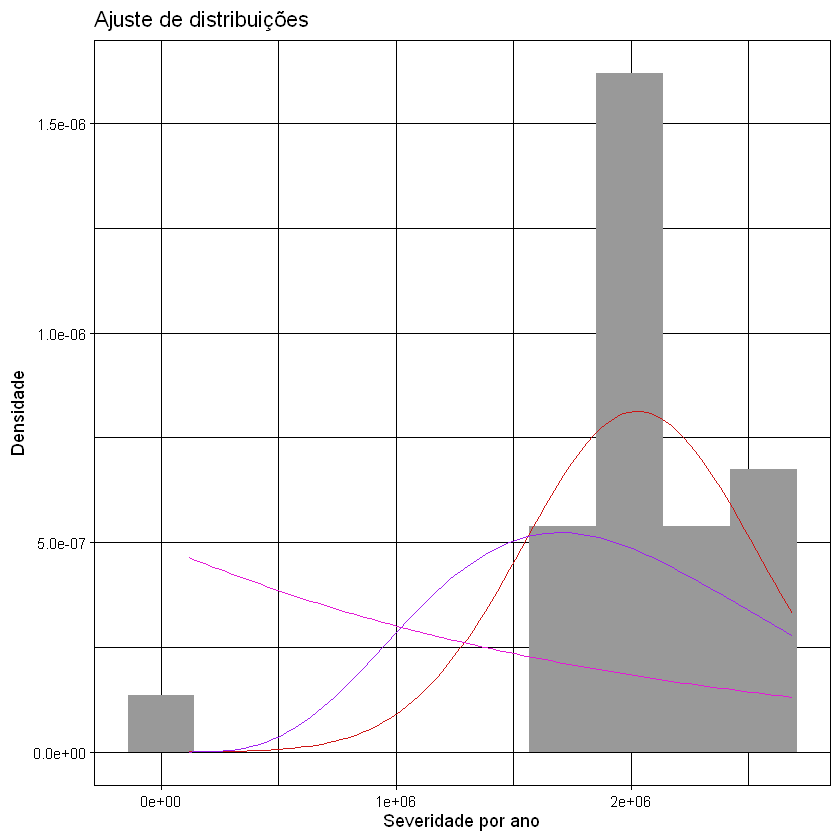

In [24]:
# Plot de densidade comparativa
ggplot(data.frame(x = dados), aes(x = x)) +
  geom_histogram(aes(y = ..density..), fill = "#999999", bins = 10) + 
  stat_function(fun = dnorm, args = list(mean = mu, sd = sigma), color = "#cd1515") +
  stat_function(fun = dexp, args = list(rate = lambda), color = "#e31ad6") +
  stat_function(fun = dgamma, args = list(shape = shape, rate = rate), color = "purple") +
  labs(title = "Ajuste de distribuições", x = "Severidade por ano", y = "Densidade") +
  theme_linedraw()

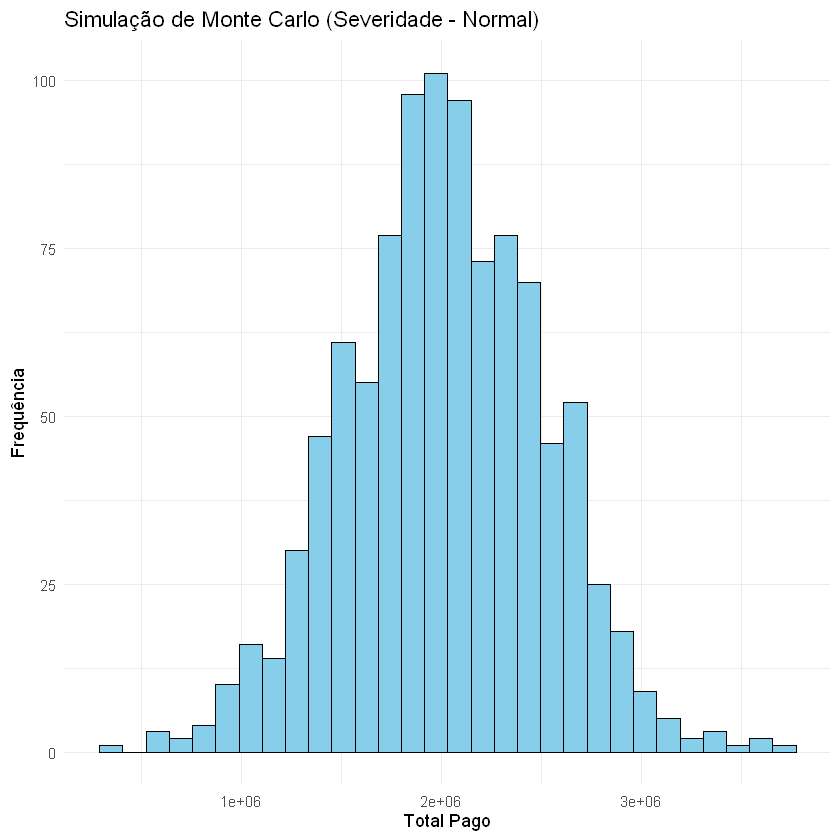

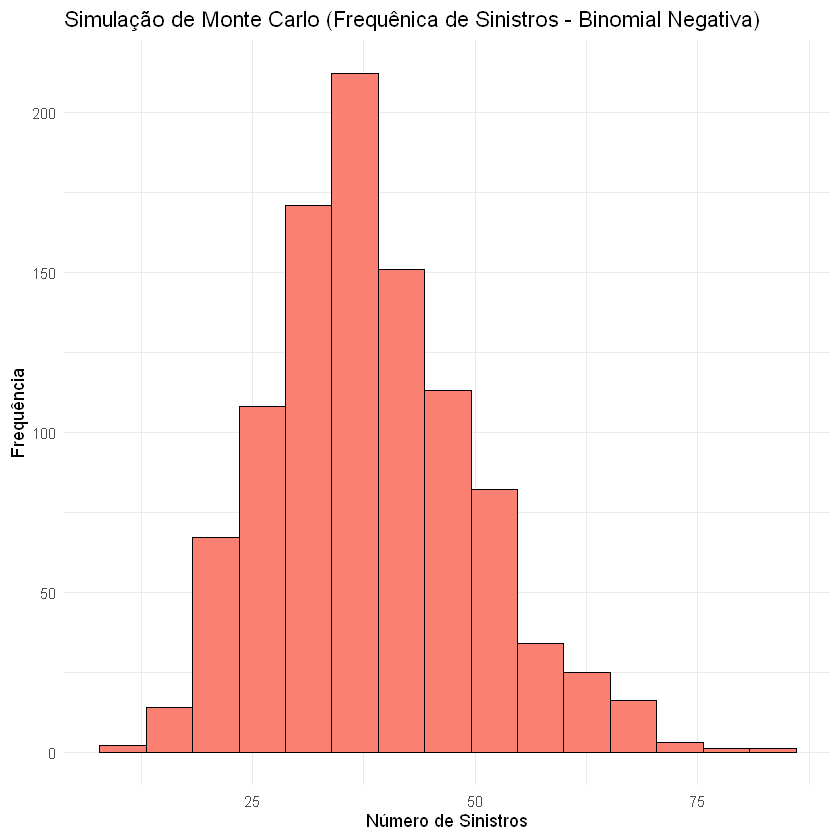

In [ ]:
# Ajustar distribuição normal para 'total_por_ano'
ajuste_norm <- fitdist(carteira_agrupada$total_por_ano, "norm")
mu <- ajuste_norm$estimate[1]
sigma <- ajuste_norm$estimate[2]

# Ajustar distribuição binomial negativa para 'quantidade_sinistros'
ajuste_nbinom <- fitdist(carteira_agrupada$quantidade_sinistros, "nbinom")
size <- ajuste_nbinom$estimate["size"]
mu_nbinom <- ajuste_nbinom$estimate["mu"]

set.seed(42) 

sim_total <- rnorm(n = 1000, mean = mu, sd = sigma)
sim_quantidade <- rnbinom(n = 1000, size = size, mu = mu_nbinom)

# Criar dataframe com as simulações
simulacoes <- data.frame(
  total_por_ano = sim_total,
  quantidade_sinistros = sim_quantidade
)
# Histograma para total_por_ano
ggplot(simulacoes, aes(x = total_por_ano)) +
  geom_histogram(fill = "skyblue", color = "black", bins = 30) +
  labs(title = "Simulação de Monte Carlo (Severidade - Normal)",
       x = "Total Pago", y = "Frequência") +
  theme_minimal()

# Histograma para quantidade_sinistros
ggplot(simulacoes, aes(x = quantidade_sinistros)) +
  geom_histogram(fill = "salmon", color = "black", bins = 15) +
  labs(title = "Simulação de Monte Carlo (Frequênica de Sinistros - Binomial Negativa)",
       x = "Número de Sinistros", y = "Frequência") +
  theme_minimal()



In [21]:
# Precificando a partir das simulações

# Premio de risco
E <- mean(simulacoes$total_por_ano)*mean(simulacoes$quantidade_sinistros)
pr <- E; pr

# Premio puro
theta <- 0.1
pp <- E*(1+theta); pp

[1] 77354457

[1] 85089902